## Lab Work 5: Fair Evaluation and Monte Carlo

This notebook builds on the third lecture of Foundations of Machine Learning. We'll focus on Fair Evaluation and Monte Carlo.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

First the necessary imports:


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.base import clone

### 1. Load the dataset

For this lecture we will use the Pulsar dataset you used in the previous Lecture.

Taks: load it, print the head and split features from target.


In [11]:
df = pd.read_csv("NB4 - Pulsars.csv")
df.head()

,Mean,Std,Excess_kurtosis,Skewness,target
0,140.562500,55.683782,-0.234571,-0.699648,0
1,102.507812,58.882430,0.465318,-0.515088,0
2,103.015625,39.341649,0.323328,1.051164,0
3,136.750000,57.178449,-0.068415,-0.636238,0
4,88.726562,40.672225,0.600866,1.123492,0


In [12]:
X = df.drop(columns=["target"])
y = df["target"]

### 2. Stratified K-Fold Cross-Validation

Goal: Split the dataset into k folds for cross-validation while preserving the proportion of classes in each fold (important for imbalanced datasets).

Procedure: use sklearn to create the stratification, the pipeline and to iterate through the splits. Then print the summary statistic (balanced accuracy).

### Accuracy vs Balanced Accuracy

**Accuracy:**

- Measures the proportion of correctly classified samples:  
   $
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$
- Works well when classes are balanced.
- Can be **misleading for imbalanced datasets**, because predicting the majority class gives high accuracy even if the model ignores the minority class.

**Balanced Accuracy:**

- Averages the recall for each class, giving equal weight to all classes:  
   $
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{\text{TP}}{\text{TP + FN}} + \frac{\text{TN}}{\text{TN + FP}} \right)
$
- Ensures the model performs well on **both majority and minority classes**.
- Particularly useful for **imbalanced classification problems**.


In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accs = []

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "logistic",
            LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=1000),
        ),
    ]
)

In [14]:
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    accs.append(acc)

In [15]:
print(f"Mean balanced accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

Mean balanced accuracy: 0.8953 ± 0.0168


try to plot std in function of the number of splits


### 3. Bootstrap

**Goal:** Estimate the variability of model performance and compute confidence intervals.

**Procedure:**

- Resample the training data **with replacement** to create bootstrap datasets.
- Use the **out-of-bag samples** as test sets.
- Fit the pipeline on each bootstrap sample and record accuracy.
- Repeat for `B` iterations and compute a **95% confidence interval** from the distribution of accuracies.
- Visualize with a histogram and mark the mean accuracy.


Resampling with replacement can result into having duplicates.
If you have 100 points without replacement samplin and create a new 100 dataset you have the same points.
OOB, out of bag samples are those that are not inside the dataset aftre sampling with replacement. they can be used as a dataset.

But the bottle neck is that this is costly, and the confidence interval can vary alot


In [16]:
def bootstrap_accuracy(model, X, y, B=400, random_state=42):
    np.random.seed(random_state)
    n = len(y)
    boot_accs = []

    for _ in range(B):
        idx = np.random.choice(
            n, n, replace=True
        )  # [0, 50, 40, 40, 40, 30] -> training
        X_train_boot = X.iloc[idx]
        y_train_boot = y.iloc[idx]

        oob_idx = np.setdiff1d(
            np.arange(n), np.unique(idx)
        )  # [0, 1, 2, 3, ... 99, 100] - [0, 30, 40, 50] = [...]
        if len(oob_idx) == 0:
            continue

        X_test_oob = X.iloc[oob_idx]
        y_test_oob = y.iloc[oob_idx]

        model_clone = clone(model)
        model_clone.fit(X_train_boot, y_train_boot)
        y_pred = model_clone.predict(X_test_oob)
        acc = balanced_accuracy_score(y_test_oob, y_pred)
        boot_accs.append(acc)

    return boot_accs

Bootstrap Mean Accuracy: 0.8954
95% Confidence Interval: [0.8815, 0.9102]


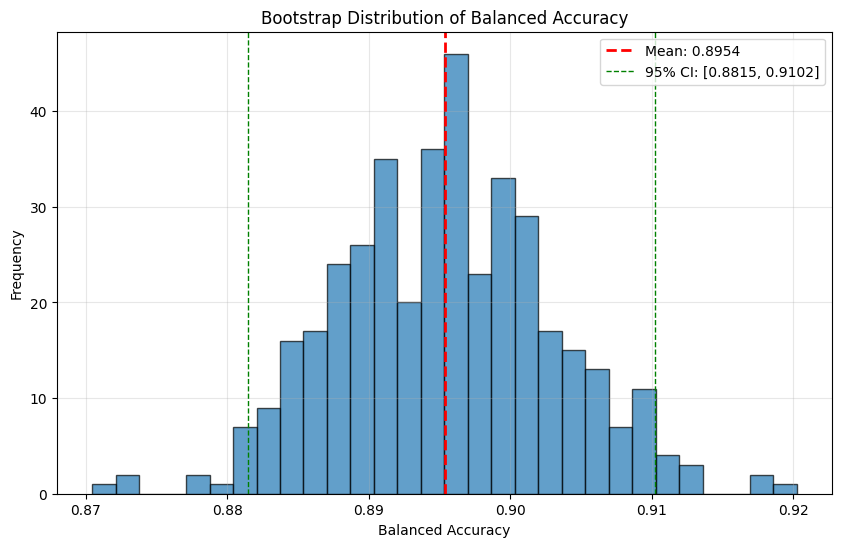

In [17]:
boot_accs = bootstrap_accuracy(pipe, X, y, B=400, random_state=42)

# Compute 95% confidence interval
ci_lower = np.percentile(boot_accs, 2.5)
ci_upper = np.percentile(boot_accs, 97.5)
mean_boot_acc = np.mean(boot_accs)

print(f"Bootstrap Mean Accuracy: {mean_boot_acc:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Visualize with histogram
plt.figure(figsize=(10, 6))
plt.hist(boot_accs, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(
    mean_boot_acc,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {mean_boot_acc:.4f}",
)
plt.axvline(
    ci_lower,
    color="green",
    linestyle="--",
    linewidth=1,
    label=f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]",
)
plt.axvline(ci_upper, color="green", linestyle="--", linewidth=1)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of Balanced Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4. Permutation Test — Single Feature

**Goal:** Assess the importance of a single feature for model performance.

**Procedure:**

- Compute baseline accuracy of the model with all features.
- Randomly **shuffle the values** of the feature of interest.
- Evaluate the model on the permuted data.
- Repeat for multiple permutations to get a distribution of accuracies.
- Compare baseline accuracy to the permuted distribution: a large drop indicates a **relevant feature**.


Baseline accuracy: 0.8953
Mean permuted accuracy: 0.8650
Drop in accuracy: 0.0303


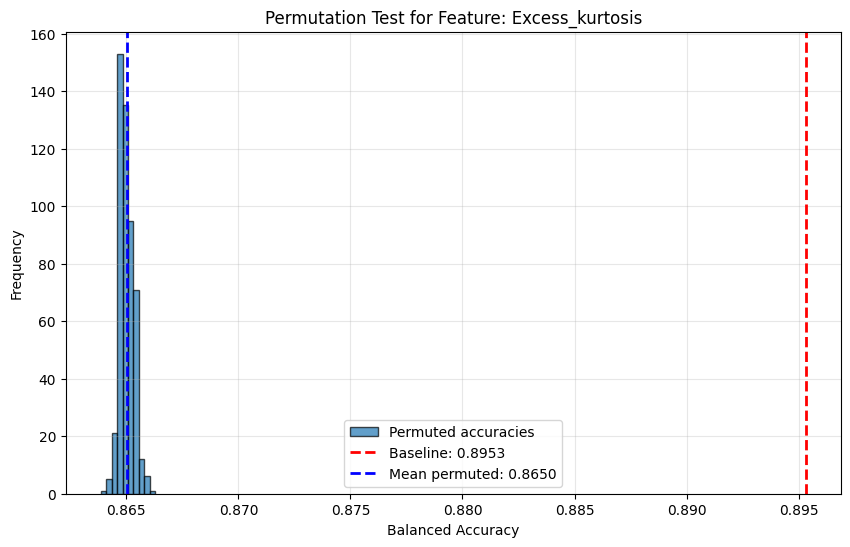

In [18]:
feature = "Excess_kurtosis"

baseline_model = clone(pipe)
baseline_model.fit(X, y)
baseline_acc = balanced_accuracy_score(y, baseline_model.predict(X))
print(f"Baseline accuracy: {baseline_acc:.4f}")

n_permutations = 500
perm_accs = []

# shuffle the feature column to break its relationship with target
for _ in range(n_permutations):
    X_perm = X.copy()
    X_perm[feature] = np.random.permutation(X_perm[feature].values)

    perm_model = clone(pipe)
    perm_model.fit(X_perm, y)
    perm_acc = balanced_accuracy_score(y, perm_model.predict(X_perm))
    perm_accs.append(perm_acc)

mean_perm_acc = np.mean(perm_accs)
print(f"Mean permuted accuracy: {mean_perm_acc:.4f}")
print(f"Drop in accuracy: {baseline_acc - mean_perm_acc:.4f}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(perm_accs, edgecolor="black", alpha=0.7, label="Permuted accuracies")
plt.axvline(
    baseline_acc,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Baseline: {baseline_acc:.4f}",
)
plt.axvline(
    mean_perm_acc,
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Mean permuted: {mean_perm_acc:.4f}",
)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.title(f"Permutation Test for Feature: {feature}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 5. Permutation Importance — All Features

**Goal:** Quantify the relevance of each feature for model performance.

**Procedure:**

- Fit the pipeline on the full dataset.
- Use `sklearn.inspection.permutation_importance` to shuffle each feature multiple times.
- Measure the decrease in model accuracy for each feature.
- Features causing a large drop are **more important**.
- Visualize the results with a bar chart of mean decreases in accuracy.


           feature  importance_mean  importance_std
2  Excess_kurtosis         0.415275        0.002979
1              Std         0.001142        0.000962
3         Skewness        -0.008899        0.001940
0             Mean        -0.017642        0.001737


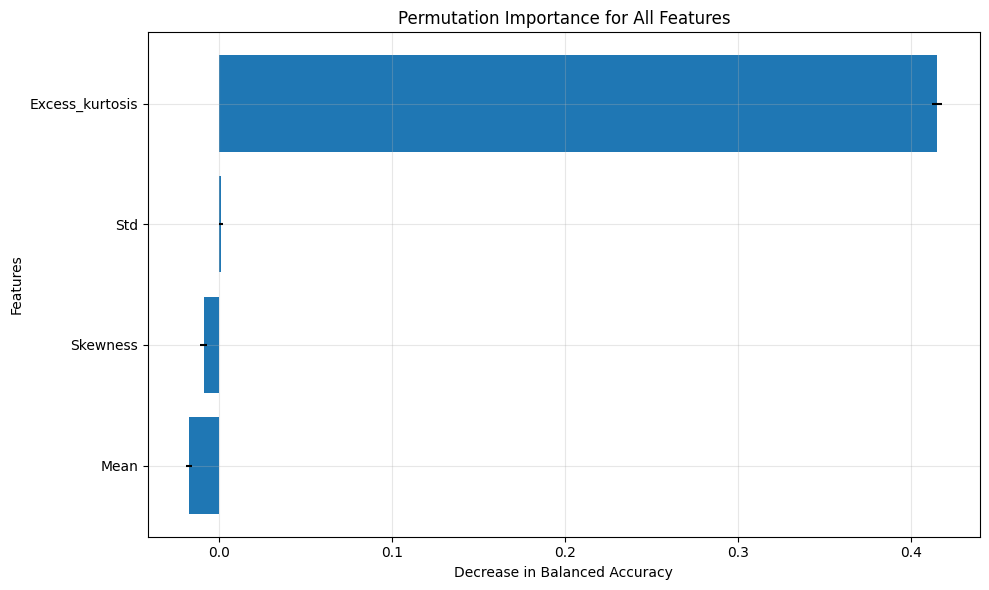

In [19]:
# evaluate decrease in accuracy when each fature i sshuffled

baseline_model.fit(X, y)

perm_importance = permutation_importance(
    baseline_model, X, y, n_repeats=1000, random_state=42, scoring="balanced_accuracy"
)

# Create a dataframe for visualization
feature_names = X.columns
importance_df = pd.DataFrame(
    {
        "feature": feature_names,
        "importance_mean": perm_importance.importances_mean,
        "importance_std": perm_importance.importances_std,
    }
).sort_values("importance_mean", ascending=False)

print(importance_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df["feature"],
    importance_df["importance_mean"],
    xerr=importance_df["importance_std"],
)
plt.xlabel("Decrease in Balanced Accuracy")
plt.ylabel("Features")
plt.title("Permutation Importance for All Features")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6. Permutation Importance for prediction vs learning

Goal: Notice the difference between predictive dependence (how much the model actually uses the feature) and learning dependence (how much the model needs the feature to achieve good performance)

Task: create two groups of features, permute and **refit**. Compare the drop in accuracy: why is it different from the single feature permutation?


Baseline accuracy (all features): 0.8953

--- Permutation WITHOUT refitting (Predictive Dependence) ---
Group 1 ['Mean', 'Std']: 0.9160 (drop: -0.0207)
Group 2 ['Excess_kurtosis', 'Skewness']: 0.4881 (drop: 0.4072)

--- Permutation WITH refitting (Learning Dependence) ---
Group 1 ['Mean', 'Std']: 0.8934 (drop: 0.0019)
Group 2 ['Excess_kurtosis', 'Skewness']: 0.8406 (drop: 0.0547)

--- Interpretation ---
Predictive dependence: measures how much the trained model relies on these features
Learning dependence: measures how important these features are for learning a good model
Group 2 (Excess_kurtosis, Skewness) shows large drop in both cases - truly important
Group 1 (Mean, Std) shows smaller drops - less important for this task


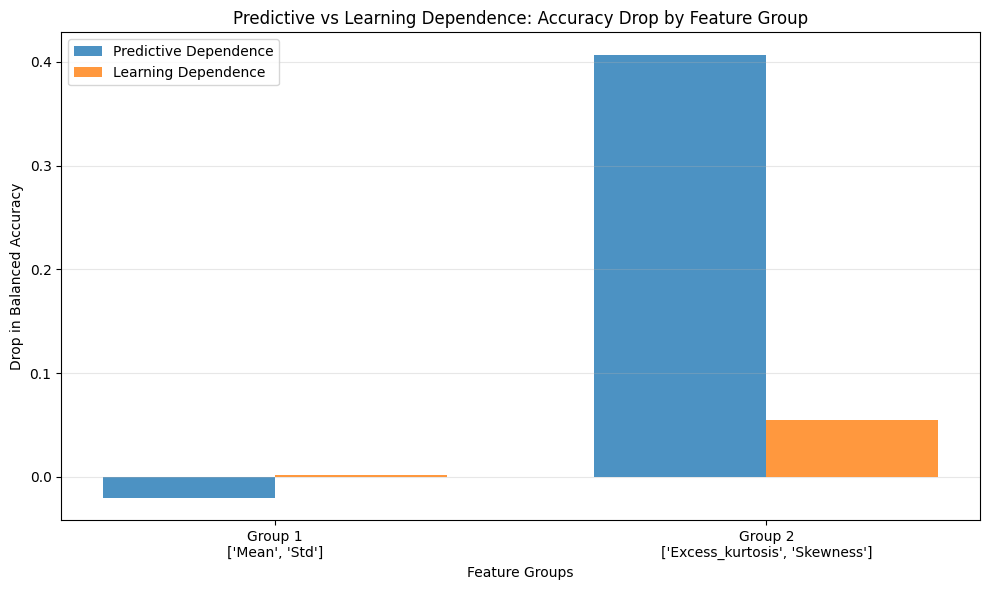

In [20]:
# Create two feature groups
group1 = ["Mean", "Std"]
group2 = ["Excess_kurtosis", "Skewness"]

# Baseline: fit model on all features
baseline_model_full = clone(pipe)
baseline_model_full.fit(X, y)
baseline_acc_full = balanced_accuracy_score(y, baseline_model_full.predict(X))
print(f"Baseline accuracy (all features): {baseline_acc_full:.4f}")

# Store results for plotting
results = {"Group": [], "Predictive Drop": [], "Learning Drop": []}

# Permutation WITHOUT refitting (predictive dependence)
print("\n--- Permutation WITHOUT refitting (Predictive Dependence) ---")
for group_name, group_features in [("Group 1", group1), ("Group 2", group2)]:
    X_perm_pred = X.copy()
    for feat in group_features:
        X_perm_pred[feat] = np.random.permutation(X_perm_pred[feat].values)

    # Use the already fitted model
    pred_acc = balanced_accuracy_score(y, baseline_model_full.predict(X_perm_pred))
    pred_drop = baseline_acc_full - pred_acc
    print(f"{group_name} {group_features}: {pred_acc:.4f} (drop: {pred_drop:.4f})")

    results["Group"].append(f"{group_name}\n{group_features}")
    results["Predictive Drop"].append(pred_drop)

# Permutation WITH refitting (learning dependence)
print("\n--- Permutation WITH refitting (Learning Dependence) ---")
for i, (group_name, group_features) in enumerate(
    [("Group 1", group1), ("Group 2", group2)]
):
    X_perm_learn = X.copy()
    for feat in group_features:
        X_perm_learn[feat] = np.random.permutation(X_perm_learn[feat].values)

    # Refit the model on permuted data
    model_refitted = clone(pipe)
    model_refitted.fit(X_perm_learn, y)
    learn_acc = balanced_accuracy_score(y, model_refitted.predict(X_perm_learn))
    learn_drop = baseline_acc_full - learn_acc
    print(f"{group_name} {group_features}: {learn_acc:.4f} (drop: {learn_drop:.4f})")

    results["Learning Drop"].append(learn_drop)

print("\n--- Interpretation ---")
print(
    "Predictive dependence: measures how much the trained model relies on these features"
)
print(
    "Learning dependence: measures how important these features are for learning a good model"
)
print(
    "Group 2 (Excess_kurtosis, Skewness) shows large drop in both cases - truly important"
)
print("Group 1 (Mean, Std) shows smaller drops - less important for this task")

# Visualize the comparison
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(
    x - width / 2,
    results_df["Predictive Drop"],
    width,
    label="Predictive Dependence",
    alpha=0.8,
)
bars2 = ax.bar(
    x + width / 2,
    results_df["Learning Drop"],
    width,
    label="Learning Dependence",
    alpha=0.8,
)

ax.set_xlabel("Feature Groups")
ax.set_ylabel("Drop in Balanced Accuracy")
ax.set_title("Predictive vs Learning Dependence: Accuracy Drop by Feature Group")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Group"])
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### 7. Monte Carlo Permutation Test

**Goal:** Test whether the model's performance is significantly better than chance.

**Procedure:**

- Randomly **permute the target labels** multiple times (B iterations).
- Fit the model on each permuted dataset and record the accuracy.
- Compare the true model accuracy to the distribution of accuracies under the null hypothesis.
- Compute the **p-value**: proportion of permuted accuracies ≥ true accuracy.
- Visualize with a histogram marking the true accuracy.


True model accuracy: 0.8953

Mean accuracy under null hypothesis: 0.5000
P-value: 0.0000
Result: Model performance is significantly better than chance (p < 0.05)


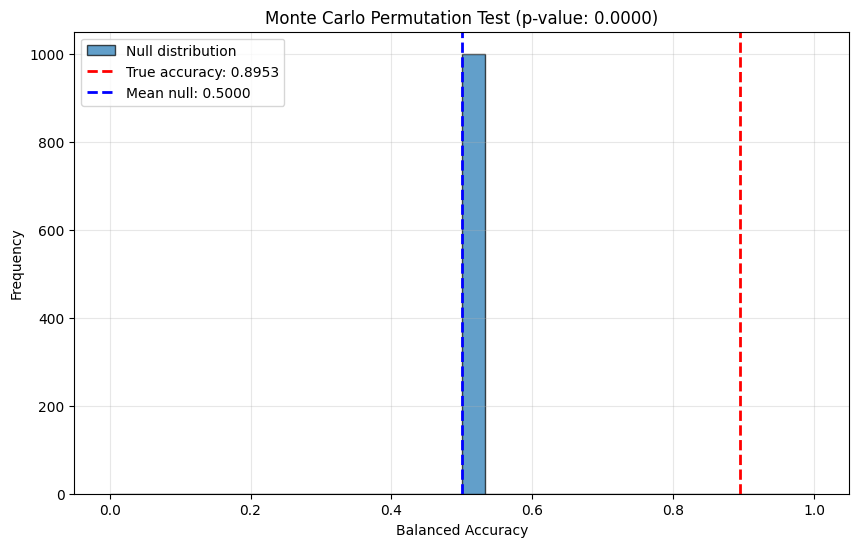

In [21]:
# Monte Carlo Permutation Test
# Goal: Test if model performance is significantly better than random chance

# Compute true baseline accuracy
true_model = clone(pipe)
true_model.fit(X, y)
true_acc = balanced_accuracy_score(y, true_model.predict(X))
print(f"True model accuracy: {true_acc:.4f}")

# Permutation test: shuffle target labels
B = 1000
null_accs = []

for _ in range(B):
    y_perm = np.random.permutation(y.values)

    model_null = clone(pipe)
    model_null.fit(X, y_perm)
    null_acc = balanced_accuracy_score(y_perm, model_null.predict(X))
    null_accs.append(null_acc)

# Compute p-value
p_value = np.mean(np.array(null_accs) >= true_acc)
print(f"\nMean accuracy under null hypothesis: {np.mean(null_accs):.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Model performance is significantly better than chance (p < 0.05)")
else:
    print(
        "Result: Model performance is NOT significantly better than chance (p >= 0.05)"
    )

# Visualize
plt.figure(figsize=(10, 6))
plt.hist(null_accs, bins=30, edgecolor="black", alpha=0.7, label="Null distribution")
plt.axvline(
    true_acc,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True accuracy: {true_acc:.4f}",
)
plt.axvline(
    np.mean(null_accs),
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Mean null: {np.mean(null_accs):.4f}",
)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.title(f"Monte Carlo Permutation Test (p-value: {p_value:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()